In [1]:
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
from drivers.tree_builder import TreeNeo
from drivers.graph_models import TreeNode, Order, Family, graph,Kingdom,Occurrence
from drivers.graph_models import Cell,Mex4km, countObjectsOf
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
import numpy as np

## Use the ggplot style
plt.style.use('ggplot')

# Spatial Regression for Abundance Data
---
Abstraction dashboard for the joininig the data with the model

***
Here I show how to extract different taxonomic information at cell level.
Although there exists a method for building the taxonomic tree within a single cell, the process can be computationally intensive because it depends on extracting the total amount of occurrences in each cell. From there, it traverses fromtop to bottom the tree looking for the corresponding nodes.

The approach is usefull when one needs a small number of trees but it'll become increasingly slow if the amount of cells or occurrences increases. 

---

## Extracting specific taxonomic levels en each cells

The method studied here makes use of the relationship type `IS_IN` stored in the knowledge graph.

> Developer's note: *There was a problem with the design of the OGM implementation (py2neo.ogm). The retrieval of linked nodes based on a specific relation does not distinguish different labels. In other words it returns the totality of the data that has the  specific relationship given a node.*

> Patchy solution: 
The solution was to include extra methods for the class Cell `has_[taxas]`. This method/attribute returns a graph selector that points to the corresponding nodes.

> Stable Fix: 
Make relationships as specific as possible (given the data). For example, if instead of using the relation type 
* *IS_IN* for (Bursera:Family) -[IS_IN]-> (Grid:Cell) 
change it to:
* *Family_IS_IN* for (Bursera:Family) -[IS_IN]-> (Grid:Cell)
Let's get started.
As usual we need to load the necessary modules


## Random selection of cells.

*Note: Data Arquitecture. For storage reasons I couldn't load the complete world bioclimatic layers. Therefore I needed to put a regional subset that comprises only the Mexican Territory. 
For this reason, it is necessary that any approach for selecting subsamples needs to be constrained (filter) by this geometry. 
We can do that with this:

In [2]:
from sketches.models import Country
from mesh.models import MexMesh

Mexico = Country.objects.filter(name__contains="exico").get()
mexican_cells = MexMesh.objects.filter(cell__intersects=Mexico.geom)

Obtain list of cells within the Mexican Territory.
> The attribute: `mexican_cells.values` is a generator of the Type: QuerySet. We need to cast it to list for loading all the data in memory.


In [3]:
# Get all cell ids
ids = list(mexican_cells.values('pk'))

In [4]:
from traversals.sampling import UniformRandomCellSample

The UniformRandomCellSample is a method for sampling cells in the example below we give as arguments. 

In [5]:
CellNodeClass = Mex4km
list_of_cell_ids = ids
n = len(ids)
selection_of_cells = UniformRandomCellSample(ids,Mex4km,sample_size=200,random_seed=12345,with_replacement=True)

INFO Using custom random seed of: 12345
INFO:biospytial.graph_models:Using custom random seed of: 12345
INFO Compiling Query and asking the Graph Database
INFO:biospytial.graph_models:Compiling Query and asking the Graph Database


The selection should be as follow:
    * Convert to pandas
    * Generate random numbers uniform on that range
    * use iloc to get the id values
    * Use the normal methodology.
    

## Extract richness and Environmental covariates from cells at a given taxonomic level
Options are: Family, Order, Spicies, etc

In [6]:
from traversals import strategies as st

In [7]:
%time data = st.getEnvironmentAndRichnessFromListOfCells(list_of_cells=selection_of_cells,taxonomic_level_name='Family')

CPU times: user 8.16 s, sys: 368 ms, total: 8.53 s
Wall time: 1min 14s


In [8]:
data.loc[:2]

,n_Family,Longitude,Latitude,Elevation_mean,MaxTemperature_mean,MeanTemperature_mean,MinTemperature_mean,Precipitation_mean,SolarRadiation_mean,Vapor_mean,WindSpeed_mean,geometry
0,4,-113.380563,27.54339,63.222222,30.225231,20.766204,30.317130,7.560185,18867.312500,1.750000,2.263889,POINT (-113.380563416 27.543389801)
1,0,-97.406563,25.68139,3.888889,27.693981,23.069444,27.807870,58.791667,16915.250000,2.212963,4.416667,POINT (-97.406563416 25.681389801)
2,2,-103.629563,22.83939,2353.000000,21.844722,13.783333,21.880556,47.480556,18051.152778,1.000000,3.113889,POINT (-103.629563416 22.839389801)


It takes time because it need to calculate on the fly the summary statistic of each cell. It is using the postgis backend

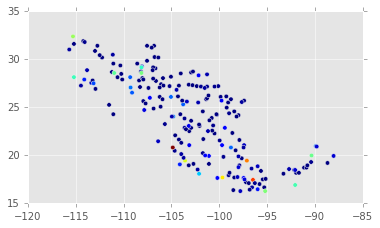

In [9]:
data.plot(column='n_Family')

## Obtaining the predictors
In this case we will bring all the variables to start working with everything

In [10]:
from raster_api.tools import RasterData
from raster_api.models import raster_models_dic as models


### Obtaining everything

In [11]:
datadict = { key : RasterData(models[key],border=Mexico.geom) for key,value in models.iteritems()}

In [12]:
## Without resamling (whole data)
pixel_size = 0.3
%time datacube_field = map(lambda raster : raster.rescale(pixel_size),datadict.itervalues())
datacube = datacube_field

CPU times: user 284 ms, sys: 4 ms, total: 288 ms
Wall time: 4min 31s


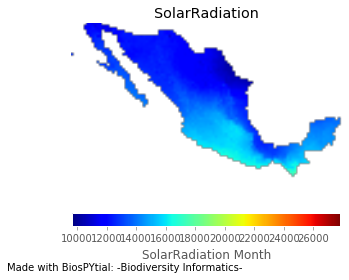

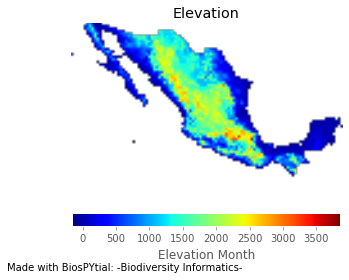

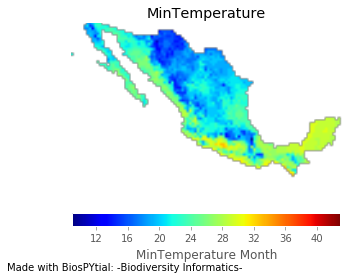

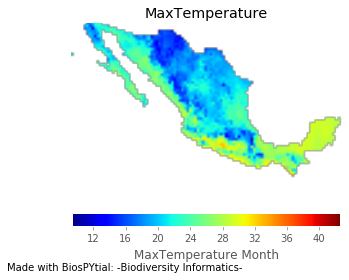

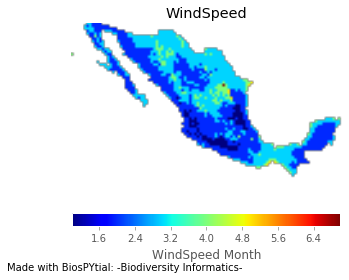

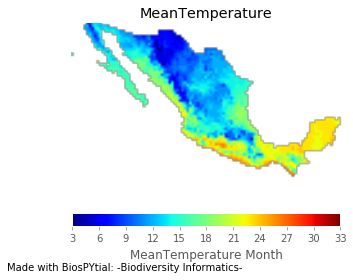

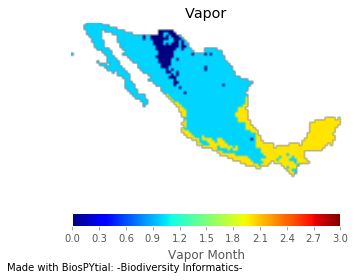

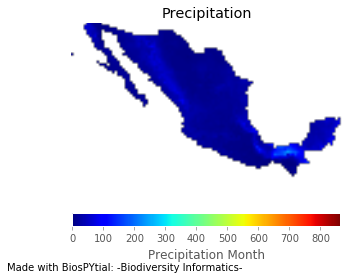

[None, None, None, None, None, None, None, None]

In [13]:
map(lambda (k,d) : d.display_field(title=k,origin='Lower'),datadict.iteritems())

## For the moment we don't want to do temporal analysis so we need to aggregate the array by the mean.

Using the new 'resample' method

In [14]:
# Take mean of evetything
cubes = map(lambda (k,v): np.mean(v.toNumpyArray(),axis=0), datadict.iteritems())

The coordinates are the same so, we can extract the them with getCoordinates and then append everything as a flat array

In [15]:
coords = map(lambda (k,v) : v.getCoordinates(),datadict.iteritems())

In [16]:
coords = pd.concat(coords,axis=1)

In [17]:
coords1 = coords[[0,1]]

In [18]:
## Oke I need a way to extract the dataframe, maybe aggregate it by mean 
dataframe_cube = map(lambda cube: pd.DataFrame(cube.flatten()),cubes)

In [19]:
datacube = pd.concat(dataframe_cube,axis=1)

In [20]:
datacube = pd.concat([datacube,coords1],axis=1)

In [21]:
datacube.columns = datadict.keys() + list(coords1.columns)

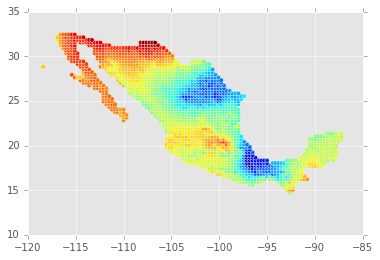

In [22]:
plt.scatter(datacube.Longitude,datacube.Latitude,c=datacube.SolarRadiation)

In [23]:
datacube.loc[:10]
datacube_clean = datacube.dropna()

In [24]:
## Convert to geopandas
from external_plugins.spystats.spystats import tools as tl
datacube_clean = tl.toGeoDataFrame(datacube_clean,xcoord_name='Longitude',ycoord_name='Latitude')

/apps/external_plugins/spystats/spystats/tools.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['geometry'] = data.apply(lambda z : Point(z[xcoord_name], z[ycoord_name]), axis=1)


# Bayesian Modelling


In [25]:
import pymc3 as pm
data.columns = [u'n_Family', u'Longitude', u'Latitude', u'Elevation_mean',
       u'MaxTemperature_mean', u'MeanTemperature_mean', u'MinTemperature_mean',
       u'Precipitation_mean', u'SolarRadiation_mean', u'Vapor_mean',
       u'WindSpeed_mean', u'geometry']

In [26]:
from statsmodels.genmod.generalized_linear_model import GLM
glmodel = GLM.from_formula('n_Family ~ Elevation_mean',data=data)
res = glmodel.fit()
print(res.summary())


z = np.array([0.0,0.0])
coefs = np.append(z,res.params.values[1:])

                 Generalized Linear Model Regression Results                  
Dep. Variable:               n_Family   No. Observations:                  199
Model:                            GLM   Df Residuals:                      197
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                   123.382814666
Method:                          IRLS   Log-Likelihood:                -760.49
Date:                Tue, 20 Mar 2018   Deviance:                       24306.
Time:                        21:40:37   Pearson chi2:                 2.43e+04
No. Iterations:                     4                                         
                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          4.1630      1.267      3.287      0.001         1.681     6.645
Elevation_mean     0.0007      0.001    

In [27]:
## cero coef for long lat
z = np.array([0.0,0.0])
coefs = np.append(z,res.params.values[1:])
print(coefs)

[ 0.          0.          0.00066554]


In [28]:
## Analysis, GP only one parameter to fit
# The variational method is much beter.
from pymc3.variational.callbacks import CheckParametersConvergence

with pm.Model() as model:
    sigma = 1.0
    #range_a=10.13
    
    
    tau = pm.Uniform('tau',0,5.0)
    #sigma = pm.Flat('sigma')
    #phi = pm.HalfNormal('phi',mu=8,sd=3)
    #phi = pm.Uniform('phi',6,12)
    phi = pm.Uniform('phi',0,15)
    
    Tau = pm.gp.cov.Constant(tau)
    
    cov = sigma * pm.gp.cov.Matern32(2,phi,active_dims=[0,1]) + Tau
    #K = cov(grid[['Lon','Lat']].values)
    #phiprint = tt.printing.Print('phi')(phi)
    
    
    mf = pm.gp.mean.Linear(coeffs=coefs,intercept=res.params.values[0])

    
    
    
    
    ## The latent function
    gp = pm.gp.Latent(cov_func=cov)
    
    
    
    
    
    ## I don't know why this
    #f = gp.prior("latent_field", X=data[['Longitude','Latitude']].values,reparameterize=False)
    
    f = gp.prior("latent_field", X=data[['Longitude','Latitude','Elevation_mean']].values,reparameterize=False)
    
    
    
    
    
    
    
    #f_print = tt.printing.Print('latent_field')(f)
    
    y_obs = pm.Poisson('y_obs',mu=np.exp(f),observed=data[['n_Family']].values)
    
    #y_obs = pm.MvNormal('y_obs',mu=np.zeros(n*n),cov=K,observed=grid.Z)

    #gp = pm.gp.Latent(cov_func=cov,observed=sample)
    # Use elliptical slice sampling
    #ess_step = pm.EllipticalSlice(vars=[f_sample], prior_cov=K)
    #step = pm.HamiltonianMC()
    #step = pm.Metropolis()
    #%time trace = pm.sample(5000,step)#,tune=0,chains=1)
    ## Variational
    
    %time mean_field = pm.fit(method='advi', callbacks=[CheckParametersConvergence()],n=15000)    
    %time trace = mean_field.sample(draws=5000)

#with model:    
    
    ## For predicting
    #%time f_star = gp.conditional("f_star", data_star.iloc[:,1:3].values)
    #%time f_star = gp.conditional("f_star", small_sample.iloc[:,1:3].values)
    %time f_star = gp.conditional("f_star", datacube_clean[['Longitude','Latitude','Elevation']].values)

    ## Full data
    ##%time f_star = gp.conditional("f_star",elev_data.iloc[:,1:3].values)


    
#with model:
    ## sampling predictions posterior predictive checks
    pred_samples = pm.sample_ppc(trace, vars=[f_star], samples=10)

                    


Average Loss = 3.1104e+05: 100%|██████████| 15000/15000 [01:21<00:00, 184.05it/s]

CPU times: user 5min 7s, sys: 16.4 s, total: 5min 24s
Wall time: 1min 24s
CPU times: user 1.72 s, sys: 124 ms, total: 1.84 s
Wall time: 840 ms
CPU times: user 2.45 s, sys: 416 ms, total: 2.87 s


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


Wall time: 727 ms


In [29]:
datacube.shape

(6466, 10)

In [30]:
preds = pd.DataFrame(pred_samples['f_star']).transpose()

In [31]:
preds['mean_sample'] = preds.mean(axis=1)

In [32]:
#preds['idx'] = data_star.index.values
preds['idx'] = datacube_clean.index.values

In [33]:

#test1 = data_s.merge(preds,how='left',left_index=True,right_on='idx',suffixes=('_obs','_pred'))
test1 = datacube.merge(preds,how='left',left_index=True,right_on='idx',suffixes=('_obs','_pred'))
## Only the values of small_sample
#test2 = elev_data.merge(preds,how='inner',left_index=True,right_on='idx',suffixes=('_obs','_pred'))

In [34]:
test1.shape

(6466, 22)

In [35]:
datacube_clean.shape

(1916, 11)

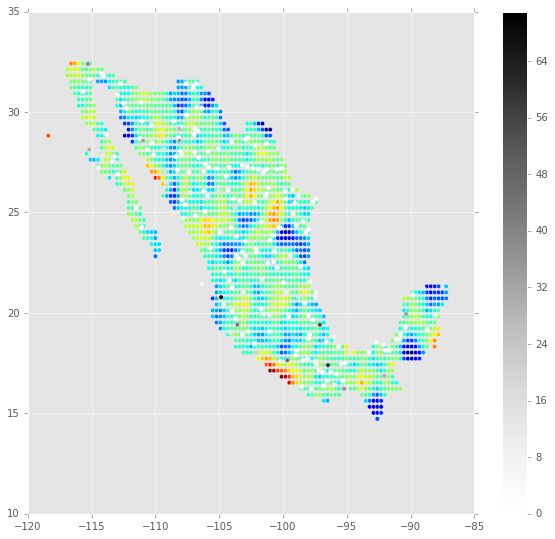

In [36]:
fig, ax = plt.subplots(figsize=(10, 9));
plt.scatter(test1.Longitude,test1.Latitude,c=test1.mean_sample)
plt.scatter(data.Longitude,data.Latitude,c=data.n_Family,cmap=plt.cm.Greys)
plt.colorbar()

# Convert to a raster format.
 ## Motivation
 It's important for visualization and compatibility with GIS software to generate the results in a standard raster format.
 For achieving this I'll explore *rasterio* package (MapBox, 2016)

In [ ]:
import rasterio as rast

In [44]:
datadict.keys()

['SolarRadiation',
 'Elevation',
 'MinTemperature',
 'MaxTemperature',
 'WindSpeed',
 'MeanTemperature',
 'Vapor',
 'Precipitation']

In [46]:
elev= datadict['Elevation']

In [51]:
b1 = elev.rasterdata.bands[0]

In [69]:
predicted_data = test1.mean_sample.values.reshape(b1.height,b1.width)

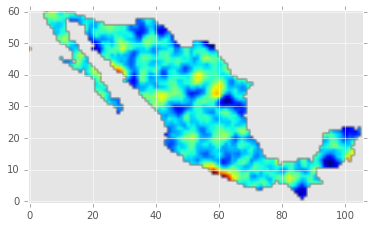

In [94]:
plt.imshow(np.exp(predicted_data),origin='Lower')

In [139]:
predicted_data_ma = np.ma.masked_invalid(predicted_data)

In [145]:
predicted_data[np.isnan(predicted_data)]=b1.nodata_value

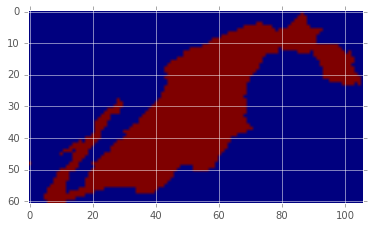

In [146]:
plt.imshow(predicted_data)

In [154]:
predicted_data[1:300:1000]

array([[ -3.27680000e+04,  -3.27680000e+04,  -3.27680000e+04,
         -3.27680000e+04,  -3.27680000e+04,  -3.27680000e+04,
         -3.27680000e+04,  -3.27680000e+04,  -3.27680000e+04,
         -3.27680000e+04,  -3.27680000e+04,  -3.27680000e+04,
         -3.27680000e+04,  -3.27680000e+04,  -3.27680000e+04,
         -3.27680000e+04,  -3.27680000e+04,  -3.27680000e+04,
         -3.27680000e+04,  -3.27680000e+04,  -3.27680000e+04,
         -3.27680000e+04,  -3.27680000e+04,  -3.27680000e+04,
         -3.27680000e+04,  -3.27680000e+04,  -3.27680000e+04,
         -3.27680000e+04,  -3.27680000e+04,  -3.27680000e+04,
         -3.27680000e+04,  -3.27680000e+04,  -3.27680000e+04,
         -3.27680000e+04,  -3.27680000e+04,  -3.27680000e+04,
         -3.27680000e+04,  -3.27680000e+04,  -3.27680000e+04,
         -3.27680000e+04,  -3.27680000e+04,  -3.27680000e+04,
         -3.27680000e+04,  -3.27680000e+04,  -3.27680000e+04,
         -3.27680000e+04,  -3.27680000e+04,  -3.27680000e+04,
        

In [91]:
b2.data().shape

(61, 106)

In [92]:
elev.rescale(pixel_size)

In [96]:
## Let´s build the new raster band
b1 = elev.rasterdata.bands[0]

In [120]:
from django.contrib.gis.gdal import GDALRaster
from raster_api.tools import GDALRasterExtended

In [165]:
rst = GDALRasterExtended({'srid': 4326,'width': b1.width,'height': b1.height,'datatype': 7,'bands': [{'data':np.exp(predicted_data_ma.flatten()),
                                                                               'size': (b1.width, b1.height),
                                                                               'nodata_value': b1.nodata_value,
                                                                              }]
                 })

In [166]:
elev.rasterdata = rst

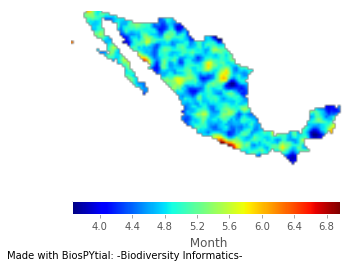

In [167]:
elev.display_field(origin='lower')

## Notas pa mi mañana.
* Verificar que es igual usar masked array en data que un array normal con el nodatavalue definido
* Añadir un nuevo attributo como rasterdata pero que se llame raster predictor
* Dependiendo el modelo el latent debe ser la exponencial o el expit del predictor.
Con esto ya se deberia de poder exportar y explorar geotif, etc.

* Hacer la modelación mas automatizada
un obejto modelo por ejemplo.



raster_api.tools.RasterData

In [169]:
np.save('/outputs/count_occurrences_dem.npy',predicted_data)

In [104]:
b1.height
b1.width
b1.pixel_count
b1.nodata_value
b1.datatype(as_string=True)

'GDT_Int16'

In [107]:
b1.data(data=predicted_data.flatten(),size=(b1.width,b1.height))

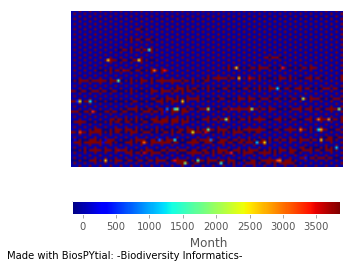

In [109]:
elev.display_field()

In [ ]:
Z = test1.mean_sample.values.reshape(61,106)
Z1 = np.ma.masked_where(Z == np.nan,Z)

In [ ]:
plt.imshow(np.exp(Z1),cmap=plt.cm.Accent)
plt.colorbar()

In [ ]:
## With pcolormesh
x = np.linspace(0,100,w)
y = np.linspace(0,100,h)
XX,YY = np.meshgrid(x,y)
ZZ = np.exp(Z1)
z_min = np.nanmin(ZZ)
z_max = np.nanmax(ZZ)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 9));
plt.pcolor(XX,YY,np.exp(Z1),cmap='RdBu', vmin=z_min, vmax=z_max)
plt.colorbar()

In [ ]:
b = elev.rasterdata.bands[0]

In [ ]:
values = b.data()

In [ ]:
from matplotlib import colors

In [ ]:
# colormap normalizer

fig, ax = plt.subplots(figsize=(10, 9));
plt.pcolor(XX,YY,values,cmap=plt.cm.CMRmap_r,norm = colors.Normalize(vmin=0.0,vmax=1800))
plt.colorbar()